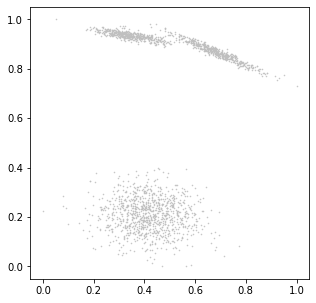

In [29]:
# 임의로 생성한 data
import numpy as np 
import numpy.matlib 
import matplotlib.pyplot as plt

# np.random.rand = uniform random generation, [0, 1]
# np.random.randn = normal random generation, N(0, 1)

# 얼마만큼 찌그러트릴지
r1 = 10*(np.random.rand(2,2) - 0.5)
r2 = 10*(np.random.rand(2,2) - 0.5)
r3 = 10*(np.random.rand(2,2) - 0.5)

# 얼마만큼 옮겨놓을지
t1 = 50*(np.random.rand(1,2) - 0.5)
t2 = 50*(np.random.rand(1,2) - 0.5)
t3 = 50*(np.random.rand(1,2) - 0.5)

X1 = np.random.randn(1000,2)
X1 = X1.dot(r1) + t1

X2 = np.random.randn(500,2)
X2 = X2.dot(r2) + t2

X3 = np.random.randn(500,2)
X3 = X3.dot(r3) + t3

# unlabel data
X = np.vstack([X1, X2, X3]) # 2000 x 2
np.random.shuffle(X) # 그 순서를 한번 섞어줌

# data -> [0, 1] 사이의 값으로 normalize
Xmin = np.min(X, axis = 0) # row vector가 한개
X = (X - Xmin) # 최소값 0으로 만듦

Xmax = np.max(X, axis = 0) # row vector가 한개
X = X / Xmax # 최소값 0, 최대값 1

plt.figure(figsize = (5,5))
plt.plot(X[:,0],X[:,1],".",markersize = 1, color = [0.75, 0.75, 0.75])

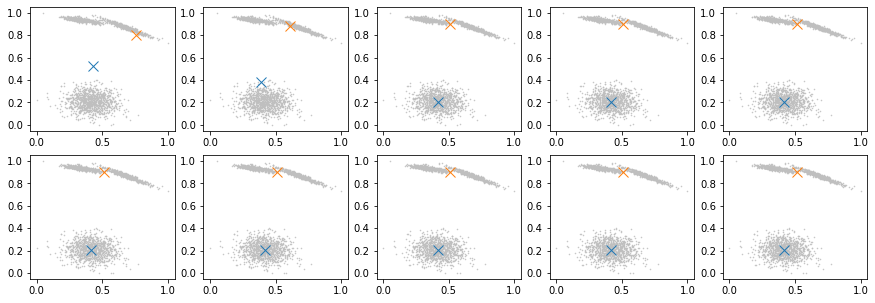

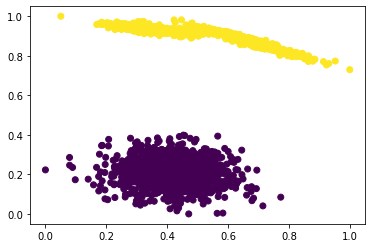

In [34]:
# kmeans clustering

# 파라미터
K = 2 # cluster의 개수
iterMax = 10 # 최대 반복할 횟수

# 초기화
# K = 클러스의 개수, N = 샘플의 개수, D = 입력 차원
N,D = X.shape # 샘플의 개수 N, 입력의 차원 D
mu = np.random.rand(K,D)
dist2 = np.zeros((N,K))

# mu의 궤적을 보기 위해서 쌓아놓으려는 값
mu_traj = np.zeros((K,D,iterMax))

plt.figure(figsize = (15,5))
for iter in range(iterMax):
    for k in range(K):
        dist2[:,k] = np.sum( (X - np.matlib.repmat(mu[k,:], N, 1))**2, axis = 1)
    label = np.argmin(dist2, axis = 1)
    for k in range(K):
        mu[k,:] = np.mean(X[label == k,:], axis = 0)
        
    plt.subplot(2,5,iter + 1)
    plt.plot(X[:,0],X[:,1],".",markersize = 1, color = [0.75, 0.75, 0.75])
    for k in range(0,K):
        plt.plot(mu[k,0],mu[k,1],"x",markersize = 10)

plt.figure()
plt.scatter(X[:,0], X[:,1], c = label)

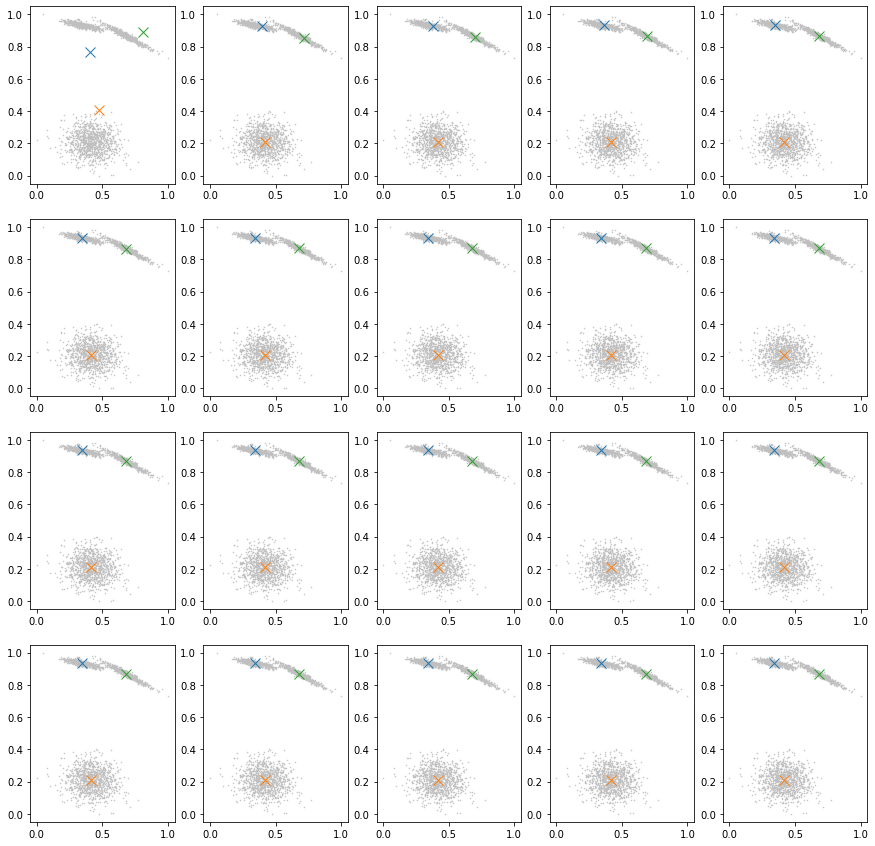

In [51]:
# MoG clustering
from scipy.stats import multivariate_normal

# 파라미터
K = 3
iterMax = 20

N,D = X.shape

# 초기 MoG 파라미터: pi(k), mu(k,:), sigma(:,:,k)
pi = np.random.rand(K)
pi = pi / np.sum(pi)
mu = np.random.rand(K,D)
sigma = np.zeros((D,D,K))
for k in range(K):
    sigma[:,:,k] = 1e-2*np.identity(D)
    
# P(x) = pi1 * N(x ; mu1, sigma1) + pi2 * N(x ; mu2, sigma2) + ...
gamma = np.zeros((N,K))
# n번째 샘플에 대해, k번째 cluster로부터 구한 responbility






plt.figure(figsize = (15,15))


for iter in range(iterMax):
    # 주어진 샘플, 주어진 파라미터 => responsibility를 구하는 스텝
    for k in range(K):
        pdf = multivariate_normal.pdf(X, mu[k,:], sigma[:,:,k])
        gamma[:,k] = pi[k] * pdf
    gamma = gamma / np.matlib.repmat(np.sum(gamma, axis = 1).reshape(-1,1), 1, K)

    label = np.argmax(gamma, axis = 1)
    plt.subplot(4,5,iter + 1)
    plt.plot(X[:,0],X[:,1],".",markersize = 1, color = [0.75, 0.75, 0.75])
    for k in range(0,K):
        plt.plot(mu[k,0],mu[k,1],"x",markersize = 10)


    # 주어진 샘플, 주어진 responsibility => 파라미터를 갱신하는 스텝
    for k in range(K):
        Nk = np.sum(gamma[:,k])

        mu[k,:] = (1/Nk) * np.sum ( np.matlib.repmat(gamma[:,k].reshape(-1,1), 1, D) * X, axis = 0)

        res = (X - np.matlib.repmat(mu[k,:].reshape(1,-1),N,1))
        gamma_res = np.matlib.repmat(gamma[:,k].reshape(N,1),1,D) * res
        for n in range(N):
            sigma[:,:,k] += res[n,:].reshape(-1,1).dot(gamma_res[n,:].reshape(-1,1).T)
        sigma[:,:,k] /= Nk

        pi[k] = Nk / N
